# Analysing Johannesburg Traffic Using Twitter Data

As part of a team during our project I was tasked with analysing the Twitter data we were given. I had to extract some insights which would then be used as part of the overall project. The purpose of the project was to analyse Sanral data and draw some insights on traffic patterns and give recommendations. Essentially this part of the project was to find out the 'why' regarding traffic patterns in Johannesburg. This notebook highlights my approach to drawing insights from the tweets. 

An important note is that this data is extremely small and so may not be a true reflection of actual patterns, it should rather highlight the approach which would be taken in such an exercise.

## Importing Packages and Data

In [2]:
import pandas as pd
import numpy as np
import swifter

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from geotext import GeoText
import geograpy
import preprocessor as p
from pprintpp import pprint as pp

import re
import urllib
import nltk
import string
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import LancasterStemmer, WordNetLemmatizer
from textblob import TextBlob, Word
from wordcloud import WordCloud, STOPWORDS
from numpy.linalg import svd

from wordcloud import WordCloud
from collections import Counter

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

/home/explore/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/home/explore/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
ewntraffic_data = pd.read_csv('ewntraffic')
gantry_loc = pd.read_csv("gantry_locations")
display(ewntraffic_data.head())
display(gantry_loc.head())

,Unnamed: 0,favorite_count,source,text,in_reply_to_screen_name,is_retweet,created_at,retweet_count,id_str
0,0,1,Twitter Web Client,Reports of a shootout in Midrand on the N1 Nor...,NaN,False,Thu Oct 30 08:07:20 +0000 2014,6,527733476574134272
1,1,0,TweetDeck,#JHBtraffic - Lioghts OUT in City Deep at Heid...,NaN,False,Tue Oct 07 04:24:29 +0000 2014,2,519342475077763072
2,2,0,TweetDeck,#JHBtraffic Lights OUT in Booysens at Booysens...,NaN,False,Tue Oct 07 04:25:14 +0000 2014,1,519342664203132928
3,3,0,Twitter Web Client,#JHBTraffic remains very slow on the N1 North ...,NaN,False,Wed Oct 22 06:44:25 +0000 2014,1,524813509654478848
4,4,1,Twitter Web Client,#JHBTraffic RT @jhbnorthmedix: Cash in Transit...,NaN,False,Tue Oct 14 06:35:48 +0000 2014,2,521912238085767168


,Unnamed: 0,Gantry,Gantry Name,Route,Latitude,Longitude,GantryN
0,0,1001,Barbet,N1,-25.7562,28.2744,1001
1,1,1002,Mossie,N1,-25.8194,28.2534,1002
2,2,1003,Indlazi,N1,-25.8443,28.2303,1003
3,3,1004,Pikoko,N1,-25.8732,28.1798,1004
4,4,1005,Ivusi,N1,-25.8978,28.1632,1005


## Exploratory Data Analysis

### Renaming Columns

In [4]:
ewntraffic_data.columns = ['column_id', 'likes', 'data_source', 
                      'text', 'responder_username', 
                      'is_retweet', 'time_tweet_created', 
                      'number_of_retweets', 'tweet_id']
ewntraffic_data.head()

,column_id,likes,data_source,text,responder_username,is_retweet,time_tweet_created,number_of_retweets,tweet_id
0,0,1,Twitter Web Client,Reports of a shootout in Midrand on the N1 Nor...,NaN,False,Thu Oct 30 08:07:20 +0000 2014,6,527733476574134272
1,1,0,TweetDeck,#JHBtraffic - Lioghts OUT in City Deep at Heid...,NaN,False,Tue Oct 07 04:24:29 +0000 2014,2,519342475077763072
2,2,0,TweetDeck,#JHBtraffic Lights OUT in Booysens at Booysens...,NaN,False,Tue Oct 07 04:25:14 +0000 2014,1,519342664203132928
3,3,0,Twitter Web Client,#JHBTraffic remains very slow on the N1 North ...,NaN,False,Wed Oct 22 06:44:25 +0000 2014,1,524813509654478848
4,4,1,Twitter Web Client,#JHBTraffic RT @jhbnorthmedix: Cash in Transit...,NaN,False,Tue Oct 14 06:35:48 +0000 2014,2,521912238085767168


Some tweets refer to traffic outside of Johannesburg, we will drop these tweets.

In [5]:
df = ewntraffic_data[ewntraffic_data['text'].str.contains('#CPTTraffic|#CPTtraffic|#DBNtraffic|#DbnTraffic') == True]
df.head()

,column_id,likes,data_source,text,responder_username,is_retweet,time_tweet_created,number_of_retweets,tweet_id
21,21,2,TweetDeck,#CPTTraffic RT @CapeTownFreeway: Roadworks: N1...,NaN,False,Tue Oct 14 08:34:36 +0000 2014,1,521942132467437568
40,40,1,TweetDeck,#CPTTraffic RT @CapeTownFreeway: Misty conditi...,NaN,False,Sun Oct 12 05:07:07 +0000 2014,4,521165142260973569
54,54,0,Twitter Web Client,#CPTTraffic • In Durmonte at the Graanendal sh...,NaN,False,Tue Oct 07 04:37:23 +0000 2014,2,519345722773499904
60,60,0,Twitter for iPad,#CPTTraffic N1 direction Cape Town still close...,NaN,False,Mon Oct 27 04:20:42 +0000 2014,1,526589278865096704
91,91,0,Twitter Web Client,#CPTTraffic RT @CapeTownTrains: #SouthernLine ...,NaN,False,Wed Oct 29 03:45:49 +0000 2014,2,527305278099042305


In [6]:
ewntraffic_data['lower_case_tweets'] = ewntraffic_data.text.swifter.apply(lambda x: x.lower())

In [7]:
ewntraffic_data.lower_case_tweets.head()

0    reports of a shootout in midrand on the n1 nor...
1    #jhbtraffic - lioghts out in city deep at heid...
2    #jhbtraffic lights out in booysens at booysens...
3    #jhbtraffic remains very slow on the n1 north ...
4    #jhbtraffic rt @jhbnorthmedix: cash in transit...
Name: lower_case_tweets, dtype: object

In [8]:
# Removing columns which refer to traffic outside of Gauteng without referencing any of the Gauteng highways.

ewntraffic = ewntraffic_data.drop(ewntraffic_data[(ewntraffic_data['lower_case_tweets'].str.contains('#cpt|#cpttraffic|#dbntraffic') == True) &
                (ewntraffic_data['lower_case_tweets'].str.contains('n1|n12|n3|r21|p119-1') == False)].index)
ewntraffic.head()

,column_id,likes,data_source,text,responder_username,is_retweet,time_tweet_created,number_of_retweets,tweet_id,lower_case_tweets
0,0,1,Twitter Web Client,Reports of a shootout in Midrand on the N1 Nor...,NaN,False,Thu Oct 30 08:07:20 +0000 2014,6,527733476574134272,reports of a shootout in midrand on the n1 nor...
1,1,0,TweetDeck,#JHBtraffic - Lioghts OUT in City Deep at Heid...,NaN,False,Tue Oct 07 04:24:29 +0000 2014,2,519342475077763072,#jhbtraffic - lioghts out in city deep at heid...
2,2,0,TweetDeck,#JHBtraffic Lights OUT in Booysens at Booysens...,NaN,False,Tue Oct 07 04:25:14 +0000 2014,1,519342664203132928,#jhbtraffic lights out in booysens at booysens...
3,3,0,Twitter Web Client,#JHBTraffic remains very slow on the N1 North ...,NaN,False,Wed Oct 22 06:44:25 +0000 2014,1,524813509654478848,#jhbtraffic remains very slow on the n1 north ...
4,4,1,Twitter Web Client,#JHBTraffic RT @jhbnorthmedix: Cash in Transit...,NaN,False,Tue Oct 14 06:35:48 +0000 2014,2,521912238085767168,#jhbtraffic rt @jhbnorthmedix: cash in transit...


### Data Overview

In [12]:
ewntraffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1139 entries, 0 to 1207
Data columns (total 10 columns):
column_id             1139 non-null int64
likes                 1139 non-null int64
data_source           1139 non-null object
text                  1139 non-null object
responder_username    27 non-null object
is_retweet            1139 non-null bool
time_tweet_created    1139 non-null object
number_of_retweets    1139 non-null int64
tweet_id              1139 non-null int64
lower_case_tweets     1139 non-null object
dtypes: bool(1), int64(4), object(5)
memory usage: 90.1+ KB


Checking for missing data.

In [13]:
def missing_data(df):
    
    # total missing values per column
    total = df.isnull().sum().sort_values(ascending=False)
    # percentage of missing values
    percent = round((df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False),2)
    # building df of missing values (Column (as index), Total, Percentage)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    
    return missing_data
missing_data(ewntraffic)

,Total,Percentage
responder_username,1112,97.63
lower_case_tweets,0,0.00
tweet_id,0,0.00
number_of_retweets,0,0.00
time_tweet_created,0,0.00
is_retweet,0,0.00
text,0,0.00
data_source,0,0.00
likes,0,0.00
column_id,0,0.00


### Likes Column

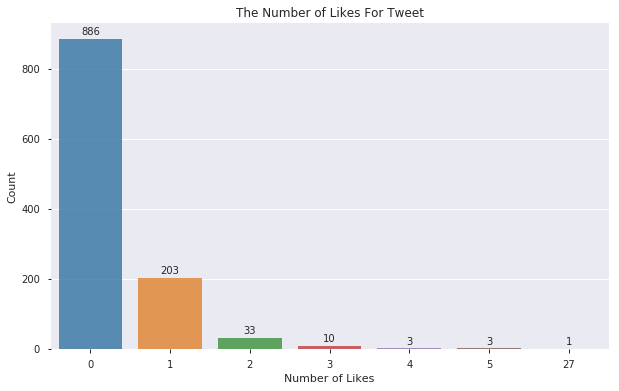

In [14]:
x = ewntraffic.likes.value_counts()
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('The Number of Likes For Tweet')
plt.ylabel('Count')
plt.xlabel('Number of Likes')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

### Data Source Column

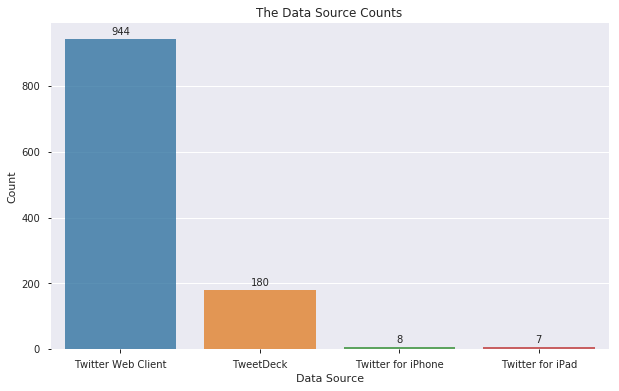

In [15]:
x = ewntraffic.data_source.value_counts()
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('The Data Source Counts')
plt.ylabel('Count')
plt.xlabel('Data Source')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

### Text Column

In [18]:
# Displaying random tweets from the text data to get a feel of what the tweets look like.

for i in np.random.randint(len(ewntraffic), size=10):
    print (ewntraffic['text'].loc[i])

#PTATraffic.In Erasmusrand there’s a stationary truck on the N1 South after Rigel Avenue Exit –two lanes closed– delays from Garsfontein
#JHBTraffic - In Tembisa there has been an accident on the R21 North after the Bapsfontein exit
#JHBTraffic - In Edenvale traffic is very slow on the R24 West between the Edenvale exit the the N12 merge
#JHBTraffic #FaultyTrafficLights in Krugersdorp at Hendrik Potgieter and the N14 - expect heavy delays in peak hour traffic
#JHBTraffic RT @BHAVS_R_09: Accident on M1 North - Double Decker  before Carr Street off ramp - 3 lanes closed http://t.co/uXHbiuyiTF
#JHBTraffic RT @righthandlane: c Olifansfontein rd today #Lawlessness http://t.co/KmbEt0Pi3J
#PTATraffic RT @netstartraffic: Stationary truck: N1 southbound after Rigel Ave, left lane affected.  http://t.co/y7wCw3aZFU
#JHBTraffic AVOID HUGE delays RT @MedixGauteng: Massive accident N12 East before Voortrekker rd in Alberton.  http://t.co/dzsmdLGFML
#JHBTraffic In Edenvale RT @itrafficgp: Accident; N

### Responder Username Column

Displaying the usernames of the accounts reponding to tweets.

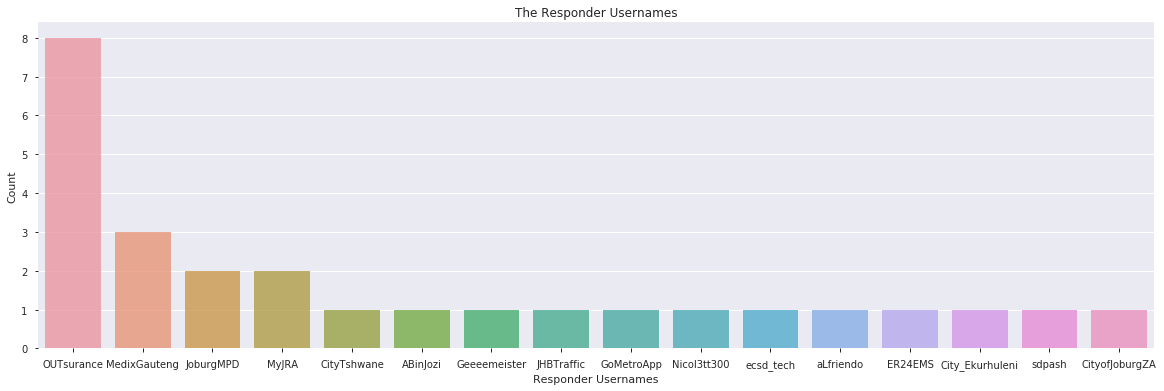

In [19]:
x = ewntraffic.responder_username.value_counts()
plt.figure(figsize=(20,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('The Responder Usernames')
plt.ylabel('Count')
plt.xlabel('Responder Usernames')
plt.show();

There are not many tweets which are responses to other tweets in this dataset. This column is likely to not be useful, however it will not be dropped and the missing values will just be replaced with the string 'None'.

In [20]:
# Filling in the missing data with 'None'.

ewntraffic['responder_username'] = ewntraffic.responder_username.fillna('None')
ewntraffic[['responder_username']].head()

,responder_username
0,None
1,None
2,None
3,None
4,None


In [21]:
ewntraffic.responder_username.value_counts()

None               1112
OUTsurance            8
MedixGauteng          3
MyJRA                 2
JoburgMPD             2
CityTshwane           1
ER24EMS               1
sdpash                1
City_Ekurhuleni       1
aLfriendo             1
ABinJozi              1
ecsd_tech             1
Nicol3tt300           1
GoMetroApp            1
JHBTraffic            1
Geeeemeister          1
CityofJoburgZA        1
Name: responder_username, dtype: int64

### Is_Retweet Column

In [22]:
ewntraffic.is_retweet.value_counts()

False    1139
Name: is_retweet, dtype: int64

### Time Tweet Created Column

In [23]:
# Checking the number of unique observations in the column.

len(ewntraffic.time_tweet_created.unique())

1139

All entries are unique, however we know that this is datetime data so let's convert the column data type to datetime, then create new columns by extracting the days, months, years, hours and minutes from the column.

In [9]:
def time_column(df, column='time_tweet_created'):
    
    df[column] =  pd.to_datetime(df[column])
    
    df['year'] = df[column].dt.year
    df['month'] = df[column].dt.month
    df['day_of_week'] = df[column].dt.dayofweek
    df['day'] = df[column].dt.day
    df['hour'] = df[column].dt.hour
    df['minute'] = df[column].dt.minute
    df['second'] = df[column].dt.second
    
    return df
ewntraffic = time_column(ewntraffic)
ewntraffic.head()

,column_id,likes,data_source,text,responder_username,is_retweet,time_tweet_created,number_of_retweets,tweet_id,lower_case_tweets,year,month,day_of_week,day,hour,minute,second
0,0,1,Twitter Web Client,Reports of a shootout in Midrand on the N1 Nor...,NaN,False,2014-10-30 08:07:20,6,527733476574134272,reports of a shootout in midrand on the n1 nor...,2014,10,3,30,8,7,20
1,1,0,TweetDeck,#JHBtraffic - Lioghts OUT in City Deep at Heid...,NaN,False,2014-10-07 04:24:29,2,519342475077763072,#jhbtraffic - lioghts out in city deep at heid...,2014,10,1,7,4,24,29
2,2,0,TweetDeck,#JHBtraffic Lights OUT in Booysens at Booysens...,NaN,False,2014-10-07 04:25:14,1,519342664203132928,#jhbtraffic lights out in booysens at booysens...,2014,10,1,7,4,25,14
3,3,0,Twitter Web Client,#JHBTraffic remains very slow on the N1 North ...,NaN,False,2014-10-22 06:44:25,1,524813509654478848,#jhbtraffic remains very slow on the n1 north ...,2014,10,2,22,6,44,25
4,4,1,Twitter Web Client,#JHBTraffic RT @jhbnorthmedix: Cash in Transit...,NaN,False,2014-10-14 06:35:48,2,521912238085767168,#jhbtraffic rt @jhbnorthmedix: cash in transit...,2014,10,1,14,6,35,48


In [25]:
ewntraffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1139 entries, 0 to 1207
Data columns (total 17 columns):
column_id             1139 non-null int64
likes                 1139 non-null int64
data_source           1139 non-null object
text                  1139 non-null object
responder_username    1139 non-null object
is_retweet            1139 non-null bool
time_tweet_created    1139 non-null datetime64[ns]
number_of_retweets    1139 non-null int64
tweet_id              1139 non-null int64
lower_case_tweets     1139 non-null object
year                  1139 non-null int64
month                 1139 non-null int64
day_of_week           1139 non-null int64
day                   1139 non-null int64
hour                  1139 non-null int64
minute                1139 non-null int64
second                1139 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(11), object(4)
memory usage: 192.4+ KB


### Retweets

Checking the number of tweets posts have received.

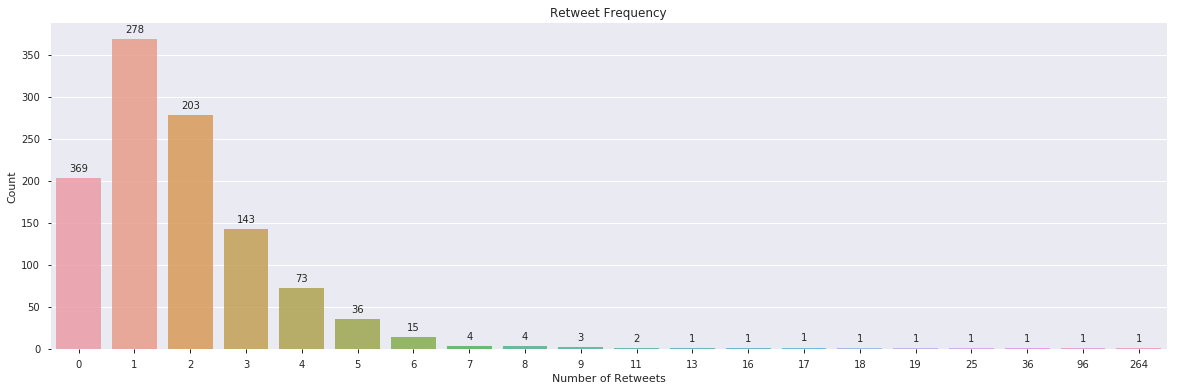

In [26]:
x = ewntraffic.number_of_retweets.value_counts()
plt.figure(figsize=(20,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Retweet Frequency')
plt.ylabel('Count')
plt.xlabel('Number of Retweets')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

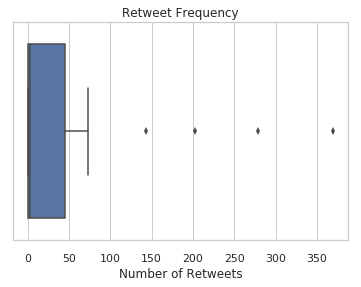

In [27]:
x = ewntraffic.number_of_retweets.value_counts()
sns.set(style='whitegrid')
ax = sns.boxplot(x)
plt.title('Retweet Frequency')
plt.xlabel('Number of Retweets')
plt.show();

### Tweet ID Column

This column is a unique identifier for the extracted tweets.

In [28]:
len(ewntraffic.tweet_id.unique())

1139

## Locations Mentioned

Locations of traffic are mentioned in some of the tweets. In order to extract these locations a package named Geograpy will be used.

In [15]:
# Searching for laocation mentions in the tweets.
df = ewntraffic.text.swifter.apply(lambda x: ', '.join(geograpy.get_place_context(text=x).cities)).str.split(',', expand=True)
df.columns = ['location_1', 'location_2', 'location_3', 'location_4', 'location_5', 'location_6']
df = df.fillna('')
ewntraffic['location_1'] = df.location_1
ewntraffic['location_2'] = df.location_2
ewntraffic['location_3'] = df.location_3
ewntraffic['location_4'] = df.location_4
ewntraffic['location_5'] = df.location_5
ewntraffic['location_6'] = df.location_6
ewntraffic.shape

(1139, 23)

Some tweets mention multiple locations, and as such require more than a single column.

In [16]:
ewntraffic.filter(df.columns).head(2)

,location_1,location_2,location_3,location_4,location_5,location_6
0,Midrand,,,,,
1,Heidelberg,,,,,


In [83]:
print(len(df.location_1.unique()), 
len(df.location_2.unique()), 
len(df.location_3.unique()), 
len(df.location_4.unique()),
len(df.location_5.unique()),
len(df.location_6.unique()))

134 62 14 3 2 2


Using a wordcloud to visualise the names of the locations which have been mentioned.

(-0.5, 799.5, 399.5, -0.5)

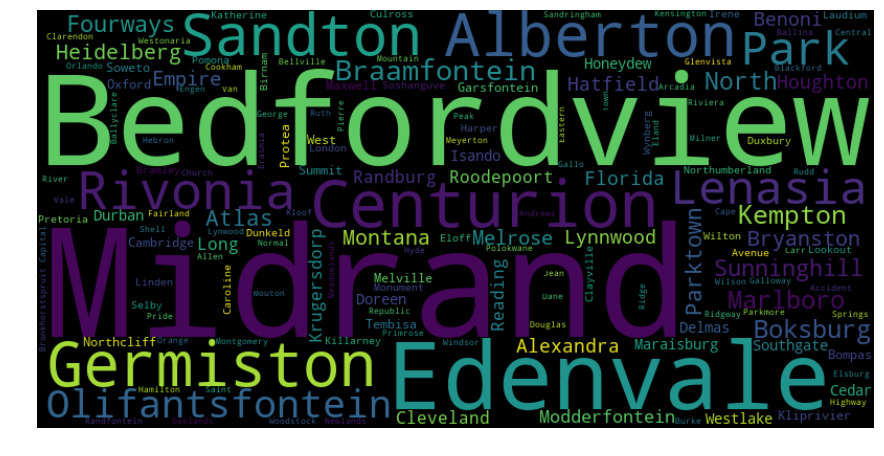

In [19]:
df = df.filter(df.columns)
places = []
for i in df.filter(df):
    for j in df[i]:
        places.extend(word_tokenize(str(j)))
    
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(frequencies = Counter(places))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Linking Locations To Coordinates

Since there are location names it is now possible to attain the coordinates for these locations.

In [20]:
from geopy.geocoders import Nominatim

In [21]:
geolocator = Nominatim(format_string='%s, South Africa')

In [36]:
# Finding the unique locations from the list created earlier while creating the wordcloud.

places = np.unique(places)

The package being used has a timeout error when too many requests are made in one go, so another package will be used which will allow the code to sleep for one second then resume.

In [1]:
# Finding the addresses for all locations and only adding the addresses listed as being in South Africa.

addresses1 = []
for i in places[:35]:
    if str(geolocator.geocode(i)).split(',')[-1] == " South Africa":
        addresses1.append(i)
        
time.sleep(1)

addresses2 = []        
for i in places[35:65]:
    if str(geolocator.geocode(i)).split(',')[-1] == " South Africa":
        addresses2.append(i) 
        
time.sleep(1)

addresses3 = []        
for i in places[65:95]:
    if str(geolocator.geocode(i)).split(',')[-1] == " South Africa":
        addresses3.append(i)
        
time.sleep(1)

addresses4 = []
for i in places[95:]:
    if str(geolocator.geocode(i)).split(',')[-1] == " South Africa":
        addresses4.append(i)
        
all_addresses = addresses1 + addresses2 + addresses3 + addresses4

With the addresses extracted the longitude and latitude for each location can now be found.

In [56]:
# finding the latitude.

latitude1 = []
for i in all_addresses[:35]:
    latitude1.append(geolocator.geocode(i).latitude)

time.sleep(1)

latitude2 = []
for i in all_addresses[35:65]:
    latitude2.append(geolocator.geocode(i).latitude)
    
time.sleep(1)
    
latitude3 = []
for i in all_addresses[65:95]:
    latitude3.append(geolocator.geocode(i).latitude)

time.sleep(1)

latitude4 = []
for i in all_addresses[95:]:
    latitude4.append(geolocator.geocode(i).latitude)
    
all_latitudes = latitude1 + latitude2 + latitude3 + latitude4

In [59]:
# finding the longitude.

longitude1 = []
for i in all_addresses[:35]:
    longitude1.append(geolocator.geocode(i).longitude)

time.sleep(1)

longitude2 = []
for i in all_addresses[35:65]:
    longitude2.append(geolocator.geocode(i).longitude)
    
time.sleep(1)
    
longitude3 = []
for i in all_addresses[65:95]:
    longitude3.append(geolocator.geocode(i).longitude)

time.sleep(1)

longitude4 = []
for i in all_addresses[95:]:
    longitude4.append(geolocator.geocode(i).longitude)
    
all_longitudes = longitude1 + longitude2 + longitude3 + longitude4

In [66]:
# Creating two dictionaries with the address and its corresponding latitude and longitude.

lat = dict(zip(all_addresses, all_latitudes))
long = dict(zip(all_addresses, all_longitudes))

In [80]:
# Mapping the latitude to each location.

lat_list = ['latitude1','latitude2','latitude3','latitude4', 'latitude5', 'latitude6']
for i, j in zip(df.columns, lat_list):
    ewntraffic[j] = ewntraffic[i].map(lat).fillna('0')
    
ewntraffic.filter(lat_list).head(2)

,latitude1,latitude2,latitude3,latitude4,latitude5,latitude6
0,-25.9993,0,0,0,0,0
1,-34.09,0,0,0,0,0


In [81]:
# Mapping the longitude to each location.

long_list = ['longitude1','longitude2','longitude3','longitude4', 'longitude5', 'longitude6']
for i, j in zip(df.columns, long_list):
    ewntraffic[j] = ewntraffic[i].map(long).fillna('0')
    
ewntraffic.filter(long_list).head(2)

,longitude1,longitude2,longitude3,longitude4,longitude5,longitude6
0,28.1259,0,0,0,0,0
1,20.9586,0,0,0,0,0


In [82]:
ewntraffic.shape

(1139, 36)

## Data Cleaning

### Removing Noise From Tweets

In [145]:
def clean_post(post):
    ''' Converts the letters in the posts to lower case 
    and removes punctuation and digits
    '''

    # Convert all words to lower-case.
    post = post.lower()
    # Removing punctuation.
    post = re.sub('[%s]' % re.escape(string.punctuation), '', post)
    post = re.sub('\w*\d\w*', '', post)
    post = re.sub('[''""...@*#*]', '', post)
    return post
# Applying operations to the text column in the dataframe.
ewntraffic['clean_tweets'] = ewntraffic['text'].swifter.apply(clean_post)
ewntraffic = ewntraffic.drop('lower_case_tweets', axis=1)
ewntraffic.clean_tweets.head(2)

0    reports of a shootout in midrand on the  north...
1    jhbtraffic  lioghts out in city deep at heidel...
Name: clean_tweets, dtype: object

### Tokenizing and Lemmatizing

In [146]:
def tokenize_lemmatize(df, text='clean_tweets'):
    '''Performs tokenisation and lemmatization on 
    the given text column.
    
    Arguments:
    df - dataframe which user wants to perform operations on.
    text - the column which operations should be performed on.
               
    Output:
    returns a dataframe with a two added columns.
    '''
    tokeniser = TreebankWordTokenizer()
    df['tokens'] = df[text].swifter.apply(tokeniser.tokenize)
    df['lemm'] = df['tokens'].swifter.apply(lambda x: ' '
                                    .join([Word(word).lemmatize()
                                           for word in x]))
    return df
  
# Tokenising and lemmatising the data using our custom function.
ewntraffic = tokenize_lemmatize(ewntraffic)
display(ewntraffic.tokens.head(2))
display(ewntraffic.lemm.head(2))

0    [reports, of, a, shootout, in, midrand, on, th...
1    [jhbtraffic, lioghts, out, in, city, deep, at,...
Name: tokens, dtype: object

0    report of a shootout in midrand on the north j...
1    jhbtraffic lioghts out in city deep at heidelb...
Name: lemm, dtype: object

## Feature Engineering

### Accidents

Finding out whether a tweet is referring to an accident and if so then along which highway.

In [3]:
# Highways with gantries.

gantry_loc['Route'].unique()

In [215]:
accident_col = []
for i in 'accident' + gantry_loc['Route'].unique():
    accident_col.append(i.strip(' '))
df = ewntraffic.copy()
df['text'] = df.text.apply(lambda x: x.lower())   
ewntraffic['accident'] = df.text.str.contains('accident|collison|crash').astype(int)

for i, j in zip(accident_col, gantry_loc['Route'].unique()):
    ewntraffic[i] = ewntraffic[ewntraffic['accident'] == 1]['text'].str.contains(j.strip(' ')).astype(int)
    ewntraffic[i] = ewntraffic[i].fillna(0)

ewntraffic.filter(accident_col).head(2)

,accidentN1,accidentN3,accidentN12,accidentR21,accidentP119-1
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0


### Locations of The Traffic and The Causes

Traffic due to accidents.

In [205]:
ewntraffic.accident.value_counts()

0    778
1    361
Name: accident, dtype: int64

There were 361 incidents of traffic due to accidents.

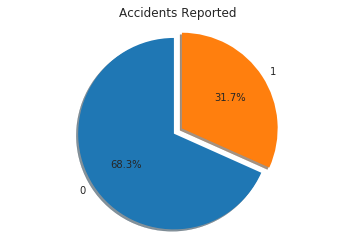

In [261]:
explode = (0.1, 0)
plt.pie(ewntraffic.accident.value_counts(), explode=explode, labels=ewntraffic.accident.unique(), shadow=True, autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Accidents Reported')
plt.axis('equal')
plt.show()

Accidents and the highways they occurred on.

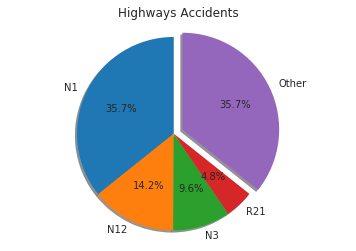

In [260]:
den = ewntraffic.accident.value_counts()[1]
N1 = (len(ewntraffic[ewntraffic.accidentN1 == 1]) / den) * 100
N12 = (len(ewntraffic[ewntraffic.accidentN12 == 1]) / den) * 100
N3 = (len(ewntraffic[ewntraffic.accidentN3 == 1]) / den) * 100
R21 = (len(ewntraffic[ewntraffic.accidentR21 == 1]) / den) * 100
Other = ((268 - (N1 + N12 + N3 + R21)) / den) * 100


labels = 'N1','N12', 'N3','R21', 'Other'
sizes = [N1, N12, N3, R21, Other]
explode = (0, 0, 0, 0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Highways Accidents')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show();

Accidents and the locations they occurred on.

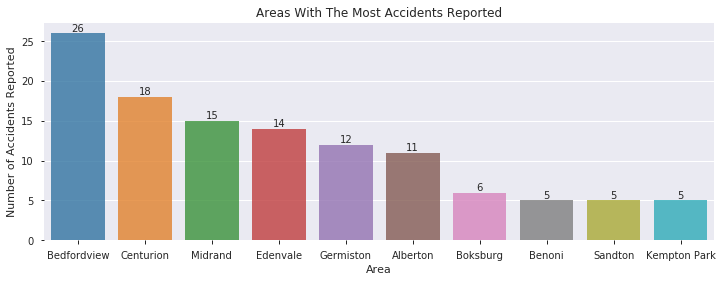

In [262]:
x = ewntraffic[(ewntraffic.accident == 1) & (ewntraffic.location_1 != '')]['location_1'].dropna()
x = x.value_counts()[:10]
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Areas With The Most Accidents Reported')
plt.ylabel('Number of Accidents Reported')
plt.xlabel('Area')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.show();

### Delays

Traffic caused by delays.

In [217]:
delays_col = []
for i in 'delays' + gantry_loc['Route'].unique():
    delays_col.append(i.strip(' '))
df = ewntraffic.copy()
df['text'] = df.text.apply(lambda x: x.lower())   
ewntraffic['delays'] = df.text.str.contains('congestion|delays|slow|delay|heist|shootout|roadworks|closed|closure|lights out|backed up').astype(int)

for i, j in zip(delays_col, gantry_loc['Route'].unique()):
    ewntraffic[i] = ewntraffic[ewntraffic['delays'] == 1]['text'].str.contains(j.strip(' ')).astype(int)
    ewntraffic[i] = ewntraffic[i].fillna(0)

ewntraffic.filter(delays_col).head(2)

,delaysN1,delaysN3,delaysN12,delaysR21,delaysP119-1
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0


In [218]:
ewntraffic.delays.value_counts()

1    637
0    502
Name: delays, dtype: int64

There were 637 instances where the traffic was caused by a delay.

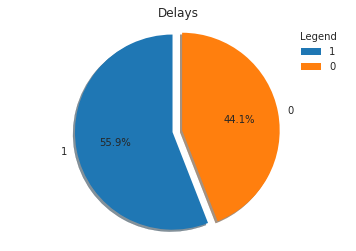

In [258]:
explode = (0.1, 0)
plt.pie(ewntraffic.delays.value_counts(), explode=explode, labels=ewntraffic.delays.unique(), shadow=True, autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Delays')
plt.axis('equal')
plt.legend(title='Legend')
plt.show()

Delays and the highways they occurred on.

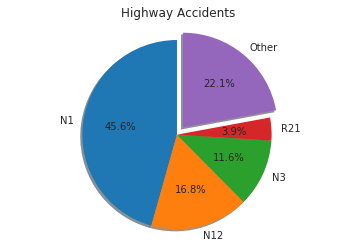

In [257]:
den = ewntraffic.accident.value_counts()[1]
N1_d = (len(ewntraffic[ewntraffic.delaysN1 == 1]) / den) * 100
N12_d = (len(ewntraffic[ewntraffic.delaysN12 == 1]) / den) * 100
N3_d = (len(ewntraffic[ewntraffic.delaysN3 == 1]) / den) * 100
R21_d = (len(ewntraffic[ewntraffic.delaysR21 == 1]) / den) * 100
Other_d = ((268 - (N1 + N12 + N3 + R21)) / den) * 100


labels = 'N1','N12', 'N3','R21', 'Other'
sizes = [N1_d, N12_d, N3_d, R21_d, Other_d]
explode = (0, 0, 0, 0, 0.1)
plt.pie(sizes, labels=labels, explode=explode, shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Highway Accidents')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show();

Delays and the locations they occurred on.

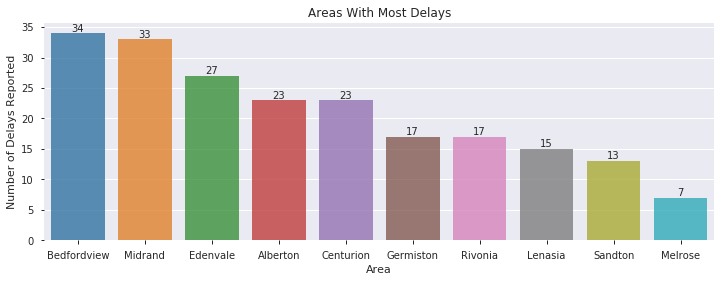

In [256]:
x = ewntraffic[(ewntraffic.delays == 1) & (ewntraffic.location_1 != '')]['location_1'].dropna()
x = x.value_counts()[:10]
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Areas With Most Delays')
plt.ylabel('Number of Delays Reported')
plt.xlabel('Area')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.show();

## Time-Based Incident Analysis

Looking at when accidents occur.

In [249]:
# Destinguishing between weekdays and weekends.

weekday = ewntraffic[ewntraffic['day_of_week'] <= 5]
weekend = ewntraffic[ewntraffic['day_of_week'] >  5]

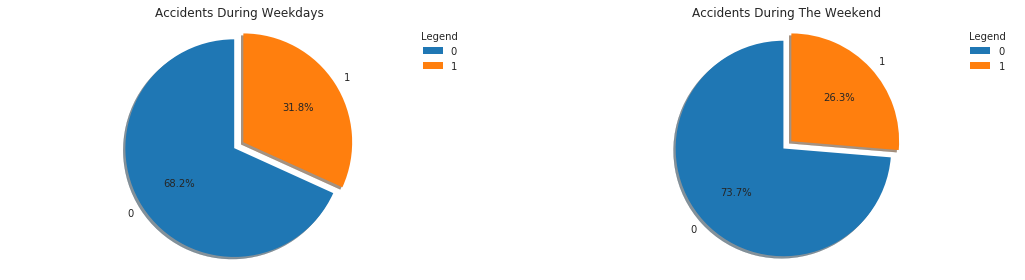

In [250]:
fig = plt.figure(figsize=(18,10))

explode = (0.1, 0)
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(weekday.accident.value_counts(), explode=explode, labels=weekday.accident.unique(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Accidents During Weekdays')
plt.axis('equal')
plt.legend(title='Legend')

explode = (0.1, 0)
ax1 = plt.subplot2grid((2, 2), (0, 1))
plt.pie(weekend.accident.value_counts(), explode=explode, labels=weekend.accident.unique(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Accidents During The Weekend')
plt.axis('equal')
plt.legend(title='Legend')

plt.show();

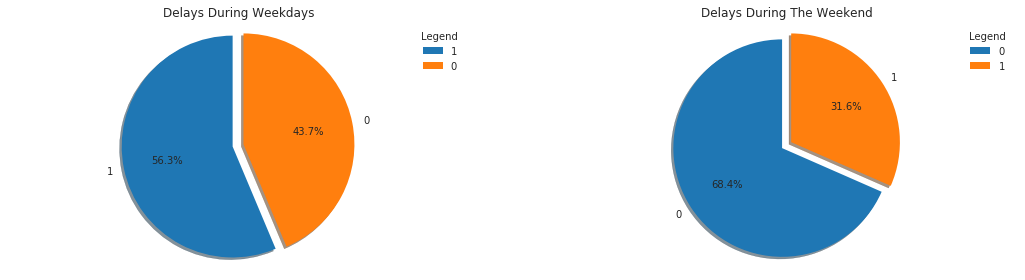

In [251]:
fig = plt.figure(figsize=(18,10))

explode = (0.1, 0)
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(weekday.delays.value_counts(), explode=explode, labels=weekday.delays.unique(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Delays During Weekdays')
plt.axis('equal')
plt.legend(title='Legend')

explode = (0.1, 0)
ax1 = plt.subplot2grid((2, 2), (0, 1))
plt.pie(weekend.delays.value_counts(), explode=explode, labels=weekend.delays.unique(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Delays During The Weekend')
plt.axis('equal')
plt.legend(title='Legend')

plt.show();

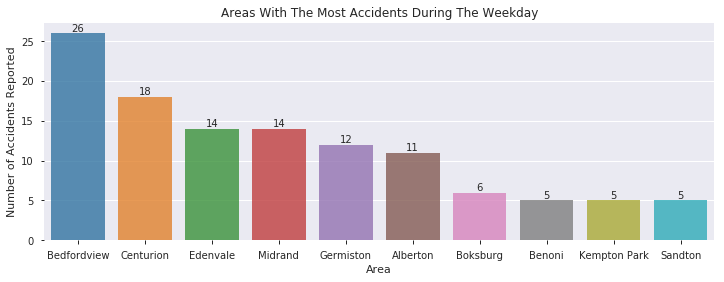

In [264]:
x = weekday[(weekday.accident == 1) & (weekday.location_1 != '')]['location_1'].dropna()
x = x.value_counts()[:10]
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Areas With The Most Accidents During The Weekday')
plt.ylabel('Number of Accidents Reported')
plt.xlabel('Area')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.show();

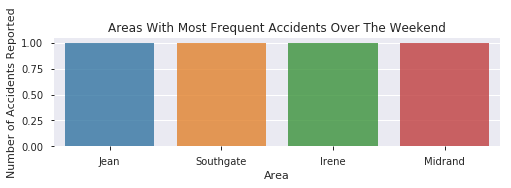

In [270]:
x = weekend[(weekend.accident == 1) & (weekend.location_1 != '')]['location_1'].dropna()
x = x.value_counts()
plt.figure(figsize=(8,2))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Areas With Most Frequent Accidents Over The Weekend')
plt.ylabel('Number of Accidents Reported')
plt.xlabel('Area')
plt.show();

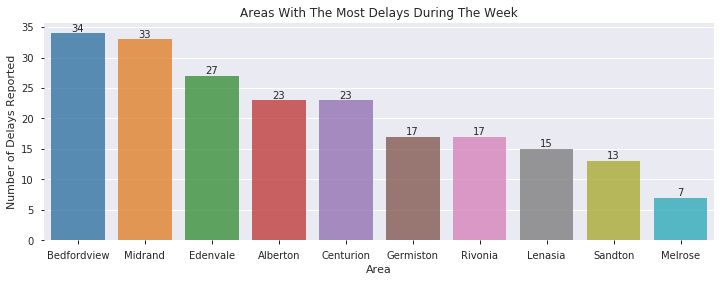

In [272]:
x = weekday[(weekday.delays == 1) & (weekday.location_1 != '')]['location_1'].dropna()
x = x.value_counts()[:10]
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Areas With The Most Delays During The Week')
plt.ylabel('Number of Delays Reported')
plt.xlabel('Area')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.show();

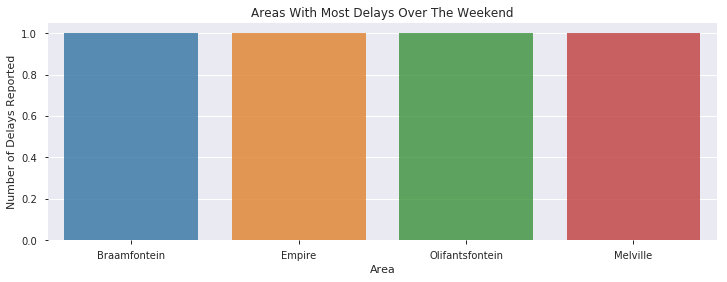

In [273]:
x = weekend[(weekend.delays == 1) & (weekend.location_1 != '')]['location_1'].dropna()
x = x.value_counts()
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Areas With Most Delays Over The Weekend')
plt.ylabel('Number of Delays Reported')
plt.xlabel('Area')
plt.show();

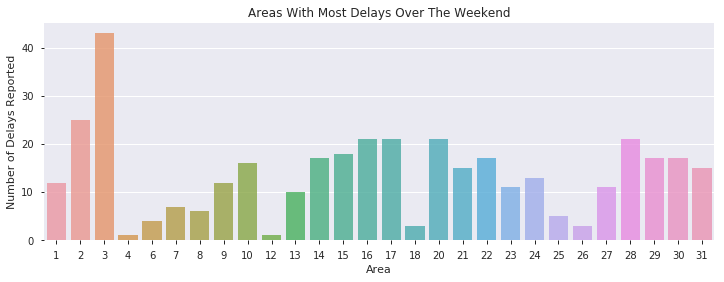

In [279]:
x = ewntraffic[(ewntraffic.delays == 1) & (ewntraffic.location_1 != '')]['day'].dropna()
x = x.value_counts()
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Delays Throughout The Month')
plt.ylabel('Number of Delays Reported')
plt.xlabel('Area')
plt.show();

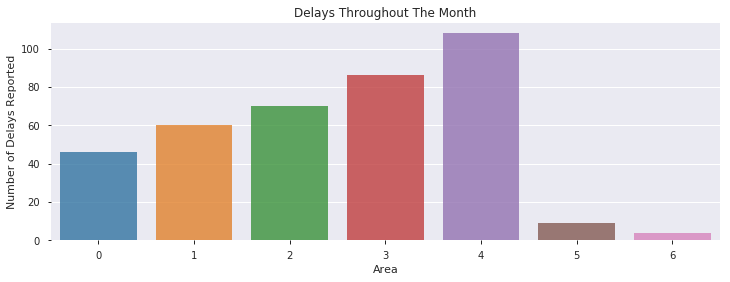

In [286]:
x = ewntraffic[(ewntraffic.delays == 1) & (ewntraffic.location_1 != '')]['day_of_week']
x = x.value_counts()
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Delays Throughout The Month')
plt.ylabel('Number of Delays Reported')
plt.xlabel('Area')
plt.show();

In [292]:
day_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ewntraffic['day_of_week'] = ewntraffic.day_of_week.map(day_dict)
ewntraffic.day_of_week.head()

0     Thursday
1      Tuesday
2      Tuesday
3    Wednesday
4      Tuesday
Name: day_of_week, dtype: object

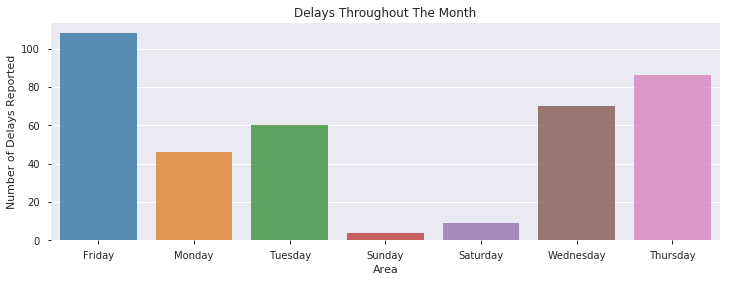

In [294]:
x = ewntraffic[(ewntraffic.delays == 1) & (ewntraffic.location_1 != '')]['day_of_week'].dropna()
x = x.value_counts(sort=False)
plt.figure(figsize=(12,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Delays Throughout The Month')
plt.ylabel('Number of Delays Reported')
plt.xlabel('Area')
plt.show();